# Segmentation de noyau

L'objectif est de prendre en main un code qui permet d'entrainer un UNet. Nous utiliserons Python et quelques librairies pour la mise en forme.

# Installation des librairies

Il s'agit de librairies qui seront utilisées pour manipuler les images et le réseau de neurone. Il contient une fonction pour simplement rendre quelques images visibles à titre d'illustration.

In [17]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import imageio
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import cv2
import tensorflow as tf
import matplotlib.patches as mpatches

!pip install livelossplot

def show_image(ix,x_train,y_train):
  fig = plt.figure(figsize=(10, 10))
  plt.subplot(121)
  plt.imshow(x_train[ix,:,:])
  plt.subplot(122)
  plt.imshow(y_train[ix, :, :, 0],cmap='gray')
  plt.axis('off')
  plt.show()

def get_data(path, train=True):
    """
    Loads and preprocesses image data.

    Args:
        path (str): Path to the directory containing the image data.
        train (bool, optional): Flag indicating if the data is for training.
                                 Defaults to True.

    Returns:
        tuple or ndarray: If train is True, returns a tuple containing the
                          image data (X) and corresponding masks (Y).
                          If train is False, returns only the image data (X).
    """
    # Get the list of image IDs
    ids = next(os.walk(path))[1]

    # Initialize arrays to store image data and masks
    X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

    # Initialize masks array only if train is True
    if train:
        Y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

    print('Getting and resizing images ... ')
    sys.stdout.flush()

    # Iterate through each image ID
    for n, id_ in tqdm(enumerate(ids), total=len(ids)):
        path_new = os.path.join(path,id_)

        # Read and resize the image
        img = imread(path_new + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X[n] = img

        # Read and process masks only if train is True
        if train:
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
            for mask_file in next(os.walk(path_new + '/masks/'))[2]:
                mask_ = imread(path_new + '/masks/' + mask_file)
                mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                              preserve_range=True), axis=-1)
                mask = np.maximum(mask, mask_)
            Y[n] = mask

    # Return image data and masks (if train is True) or only image data
    if train:
        return X, Y
    else:
        return X

def dice_coefficient(y_true, y_pred):
    eps = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    #Casting to float32 to resolve the type error
    y_true_f = tf.cast(y_true_f, dtype=tf.float32)
    y_pred_f = tf.cast(y_pred_f, dtype=tf.float32)
    intersection = K.sum(y_true_f * y_pred_f)
    # Ensure denominator is not zero by adding a small value(1e-6) to avoid division by zero errors
    result = (2. * intersection + 1e-6) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + 1e-6)
    return result

def image_confusion(GT,predict):

  # Conversion en booléen directement
  GT_new = GT.astype('uint8')

  # Création de l'image de sortie avec NumPy
  IMAGE_OUTPUT = np.zeros((GT.shape[0],GT.shape[1], 3), dtype="uint8")

  # Conditions pour chaque cas
  TP = (predict == 1) & (GT_new == 1)  # True Positive (Blanc)
  FP = (predict == 1) & (GT_new == 0)  # False Positive (Rouge)
  FN = (predict == 0) & (GT_new == 1)  # False Negative (Vert)
  TN = (predict == 0) & (GT_new == 0)  # True Negative (Noir)

  # Assignation des couleurs
  IMAGE_OUTPUT[TP] = [255, 255, 255]  # Blanc
  IMAGE_OUTPUT[FP] = [255, 0, 0]      # Rouge
  IMAGE_OUTPUT[FN] = [0, 255, 0]      # Vert
  IMAGE_OUTPUT[TN] = [0, 0, 0]        # Noir
  IMAGE_OUTPUT = np.array(IMAGE_OUTPUT)
  return IMAGE_OUTPUT

def pred_vis(x_data,y_data,preds_data,preds_data_t):
  ix = random.randint(0, len(x_data))

  gt = y_data[ix, :, :,0]
  pred = preds_data_t[ix, :, :,0]
  IMAGE_OUTPUT = image_confusion(gt,pred)
  dice = dice_coefficient(gt, pred)
  # show the plot
  fig = plt.figure(figsize=(20, 20))
  plt.subplot(151)
  plt.imshow(x_data[ix,:,:])
  plt.title("input image")
  plt.axis('off')
  plt.subplot(152)
  plt.imshow(np.squeeze(y_data[ix, :, :, 0]),cmap='gray')
  plt.title("ground truth")
  plt.axis('off')
  plt.subplot(153)
  plt.imshow(np.squeeze(preds_data[ix, :, :]))
  plt.title("Probability map of the predicted mask")
  plt.axis('off')
  plt.subplot(154)
  plt.imshow(np.squeeze(preds_data_t[ix, :, :, 0]),cmap='gray')
  plt.title("Probability map thresholded\n Dice "+str(np.around(dice,3)))
  plt.axis('off')
  plt.subplot(155)
  plt.imshow(IMAGE_OUTPUT)
  legend_patches = [
        mpatches.Patch(color='white', label='True Positive (Blanc)'),
        mpatches.Patch(color='red', label='False Positive (Rouge)'),
        mpatches.Patch(color='green', label='False Negative (Vert)'),
        mpatches.Patch(color='black', label='True Negative (Noir)'),
    ]
  plt.legend(handles=legend_patches, loc='upper left',bbox_to_anchor=(1.1,.9), fontsize=10, frameon=True)
  plt.title("Image de confusion")
  plt.axis('off')
  plt.show()

def vis_prob_maps(x_data,y_data,preds_test):
  ix = random.randint(0, len(x_data))
  gt = Y_test[ix, :,:,0]
  rgb = X_test[ix,:,:]
  map_pred = preds_test[ix,...]

  # show the plot
  fig = plt.figure(figsize=(20, 20))
  plt.subplot(151)
  plt.imshow(rgb)
  plt.title("input image")
  plt.axis('off')
  plt.subplot(152)
  plt.imshow(np.squeeze(gt),cmap='gray')
  plt.title("ground truth")
  plt.axis('off')
  plt.subplot(153)
  plt.imshow(np.squeeze(map_pred))
  plt.title("Probability map")
  plt.axis('off')
  plt.show()

def thr_optimize(preds_data):
  from sklearn.metrics import f1_score

  # compute F1-score for a set of thresholds from (0.1 to 0.9 with a step of 0.1)
  prob_thresh = [i*10**-1 for i in range(1,10)]
  perf=[] # define an empty array to store the computed F1-score for each threshold
  perf_ALL=[]
  for r in tqdm(prob_thresh): # all th thrshold values
      preds_bin = ((preds_data> r) + 0 )
      preds_bin1=preds_bin[:,:,:,0]
      GTALL=y_val[:,:,:,0]
      for ii in range(len(GTALL)): # all validation images
          predmask=preds_bin1[ii,:,:]
          GT=GTALL[ii,:,:]
          l = GT.flatten()
          p= predmask.flatten()
          perf.append(f1_score(l, p)) # re invert the maps: cells: 1, back :0
      perf_ALL.append(np.mean(perf))
      perf=[]

  plt.figure(figsize=(10,10))
  plt.plot(prob_thresh, perf_ALL,'ro-')
  plt.ylim(top=1)
  plt.xticks(prob_thresh)
  plt.tick_params(axis='x', labelsize=12)
  plt.tick_params(axis='y', labelsize=12)
  plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
  plt.xlabel('predicted probability map threshold',fontsize=12)
  plt.ylabel('F1-score', fontsize=12)
  None;
  max_f1 = max(perf_ALL)  # Find the maximum y value
  op_thr = prob_thresh[np.array(perf_ALL).argmax()]  # Find the x value corresponding to the maximum y value
  plt.title('Best threshold is: '+str(op_thr)+' for F1-score='+str(np.around(max_f1,3)),fontsize=14)
  print("Optimizing threshold for predicted probability maps")

# Importation des données

Nous utilserons les données ESRF pour la pise en main du code. Cette base de données contient des images de noyau segmentée.

In [ ]:
from google.colab import drive
root = '/content/gdrive/'
drive.mount(root)

# create permanent directory in gdrive
data_dir_path = '/MyDrive/Segmentation/'
os.makedirs(os.path.join(root,data_dir_path), exist_ok=True)
os.listdir(os.path.join(root,data_dir_path))

Mounted at /content/gdrive/


[]

Télécharger le [base de donnée](https://drive.google.com/file/d/1ZNoqmFJVK-1n9CtgfNI1B2UrKs_5aZRA/view?usp=drive_link) puis déposer le dans votre dossier **Segmentation**

In [ ]:
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'data/nuclei_train_data/'
TEST_PATH = 'data/nuclei_val_data/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

X, Y = get_data(TRAIN_PATH, train=True)
X_test,Y_test = get_data(TEST_PATH, train=True)

Getting and resizing images ... 


100%|██████████| 536/536 [04:34<00:00,  1.95it/s]

Getting and resizing images ... 



100%|██████████| 134/134 [01:27<00:00,  1.52it/s]


In [19]:
print('Train data shape:', X.shape)
print('Train label shape:', Y.shape)
print('Test data shape:', X_test.shape)
print('Test label shape:', Y_test.shape)

Train data shape: (536, 256, 256, 3)
Train label shape: (536, 256, 256, 1)
Test data shape: (134, 256, 256, 3)
Test label shape: (134, 256, 256, 1)


# Constituter une base de données train et validation

In [21]:
!pip install -q scikit-learn

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42) #text_size=0.3 (à moi, 0.2)

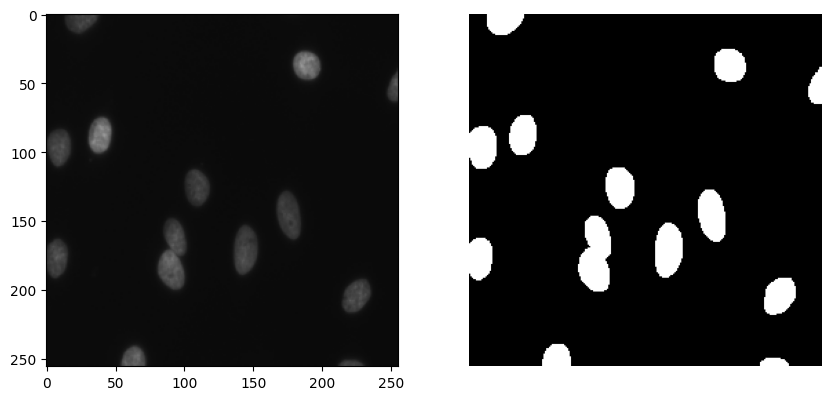

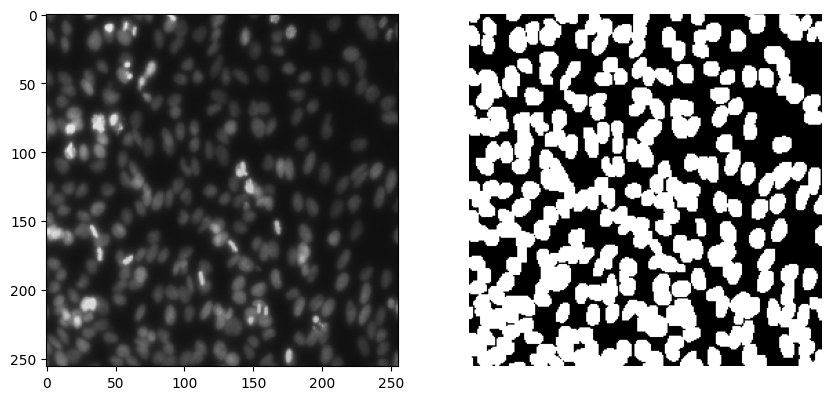

In [23]:
show_image(5,x_train,y_train)
show_image(75,x_train,y_train)

# Modèle UNet

In [24]:
#Each block of u-net architecture consist of two Convolution layers
# These two layers are written in a function to make our code clean
def conv2d_block(input_tensor, n_filters,kernel_size=3):
    x = Conv2D(filters=n_filters,kernel_size=(kernel_size, kernel_size),activation='relu', padding="same")(input_tensor)
    x = Conv2D(filters=n_filters,kernel_size=(kernel_size, kernel_size),activation='relu', padding="same")(x)
    return x

# The u-net architecture consists of contracting and expansive paths which
# shrink and expands the inout image respectivly.
# Output image have the same size of input image
def get_unet(input_img, n_filters):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*4, kernel_size=3) #The first block of U-net
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = conv2d_block(p1, n_filters=n_filters*8, kernel_size=3)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = conv2d_block(p2, n_filters=n_filters*16, kernel_size=3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = conv2d_block(p3, n_filters=n_filters*32, kernel_size=3)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = conv2d_block(p4, n_filters=n_filters*64, kernel_size=3) # last layer on encoding path

    # expansive path
    u6 = Conv2DTranspose(n_filters*32, (3, 3), strides=(2, 2), padding='same') (c5) #upsampling included
    u6 = concatenate([u6, c4])
    c6 = conv2d_block(u6, n_filters=n_filters*32, kernel_size=3)

    u7 = Conv2DTranspose(n_filters*16, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = conv2d_block(u7, n_filters=n_filters*16, kernel_size=3)

    u8 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = conv2d_block(u8, n_filters=n_filters*8, kernel_size=3)

    u9 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv2d_block(u9, n_filters=n_filters*4, kernel_size=3)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

Définition des hyperparamètres de l'architecture:
- Nombre de filtre

In [25]:
# Creating and Compiling the model
input_img = Input((x_train.shape[1], x_train.shape[2], 3), name='img')
model = get_unet(input_img, n_filters=3)

Définition des hyperparamètres pour l'apprentissage:

1ère groupe:

- Algorithme d'optimisation
- Fonction de perte (dans le cas d'une segmentation)
- Métrique (dans le cas d'une segmentation)

In [ ]:
# # Code Weighted Loss

# from collections import Counter
# import numpy as np

# # Flatten the y_train_ensemble to get all pixel values
# PIXEL = np.array(y_train).flatten()
# temp_dico = Counter(PIXEL) # Count the occurrences of each pixel value
# s = sum(temp_dico.values()) # Calculate the total number of pixels
# dico = {x: 1 - count / s for x, count in temp_dico.items()} # Normalize the pixel counts
# print('PIXEL :', temp_dico.values())
# print('PIXEL normalized :', dico.values())
# temp_list = list(dico.values())
# white_pixel = dico[True]
# print(temp_list, '/ somme :', sum(temp_list))

PIXEL : dict_values([4722041, 23327367])
PIXEL normalized : dict_values([0.8316527393376716, 0.1683472606623284])
[0.8316527393376716, 0.1683472606623284] / somme : 1.0


In [26]:
model.compile(optimizer=Adam(learning_rate=0.0007), loss="binary_crossentropy", metrics=[dice_coefficient])
# model.compile(optimizer=Adam(learning_rate=0.0007), loss="binary_crossentropy", metrics=[dice_coefficient],loss_weights=[white_pixel]) #loss weighted
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)    │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        336 │ img[0][0]         │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      1,308 │ conv2d[0][0]      │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      2,616 │ max_pooling2d[0]… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      5,208 │ conv2d_2[0][0]    │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     10,416 │ max_pooling2d_1[… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     20,784 │ conv2d_4[0][0]    │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     41,568 │ max_pooling2d_2[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │     83,040 │ conv2d_6[0][0]    │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │    166,080 │ max_pooling2d_3[… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │    331,968 │ conv2d_8[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    165,984 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 1,214,677 (4.63 MB)

 Trainable params: 1,214,677 (4.63 MB)

 Non-trainable params: 0 (0.00 B)

2ème groupe:
- Early Stopping
- Sauvegarde du meilleur modèle

In [ ]:
checkpoint_filepath = os.path.join(root,data_dir_path,'unet_best.keras')

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, verbose=1, mode='auto') #Stop training when a monitored metric has stopped improving.

Model_check = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto') #Callback to save the Keras model or model weights at some frequency.

3e groupe:

- Nombre de batch
- Nombre d'epoch

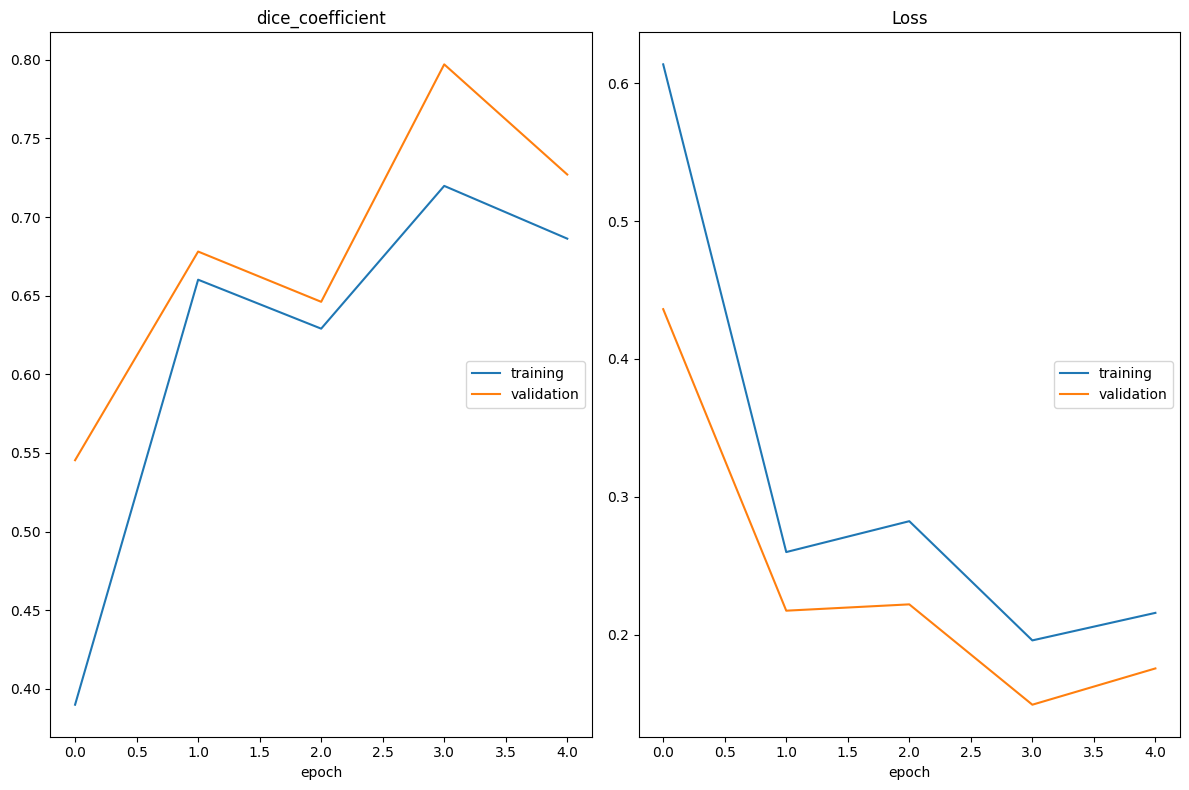

dice_coefficient
	training         	 (min:    0.390, max:    0.720, cur:    0.686)
	validation       	 (min:    0.545, max:    0.797, cur:    0.727)
Loss
	training         	 (min:    0.196, max:    0.614, cur:    0.216)
	validation       	 (min:    0.149, max:    0.436, cur:    0.176)

Epoch 5: val_loss did not improve from 0.14923
214/214 ━━━━━━━━━━━━━━━━━━━━ 24s 110ms/step - dice_coefficient: 0.7074 - loss: 0.2097 - val_dice_coefficient: 0.7270 - val_loss: 0.1755


In [29]:
# Fiting the model
from livelossplot import PlotLossesKeras
plotlossesdeeper = PlotLossesKeras()
results = model.fit(x_train, y_train,
                    validation_data=(x_val,y_val),
                    batch_size=2, epochs=5,
                    verbose=1,
                    callbacks=[plotlossesdeeper,early_stop,Model_check])

# Evaluation du meilleur modèle

In [30]:
model_best = tf.keras.models.load_model(checkpoint_filepath,custom_objects={'dice_coefficient': dice_coefficient})

In [31]:
model_best.evaluate(X_test,Y_test,return_dict=True) #Evaluation of the model on the test dataset

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - dice_coefficient: 0.8086 - loss: 0.1530


{'dice_coefficient': 0.8081129193305969, 'loss': 0.15383416414260864}

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 325ms/step


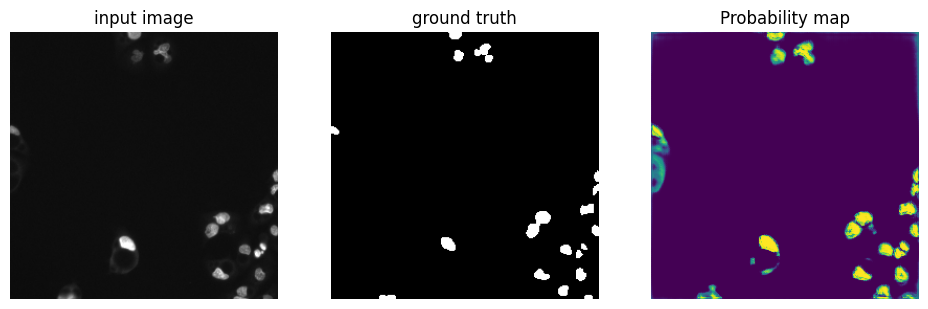

In [32]:
preds_test = model_best.predict(X_test, verbose=1)
vis_prob_maps(X_test,Y_test,preds_test)

## En post-traitement, comment passer d'une carte de probabilité à une vérité terrain ?

On va appliquer un seuillage simple sur la carte de probabilité

In [ ]:
preds_val = model_best.predict(x_val, verbose=1)
preds_val_t = (preds_val > 0.6).astype(np.uint8) # we apply a threshold on predicted mask (probability mask) to convert it to a binary mask.

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step


In [ ]:
dice = K.get_value(dice_coefficient(y_val, preds_val_t))
print("Dice coefficient:", np.around(dice,3))

Dice coefficient: 0.852


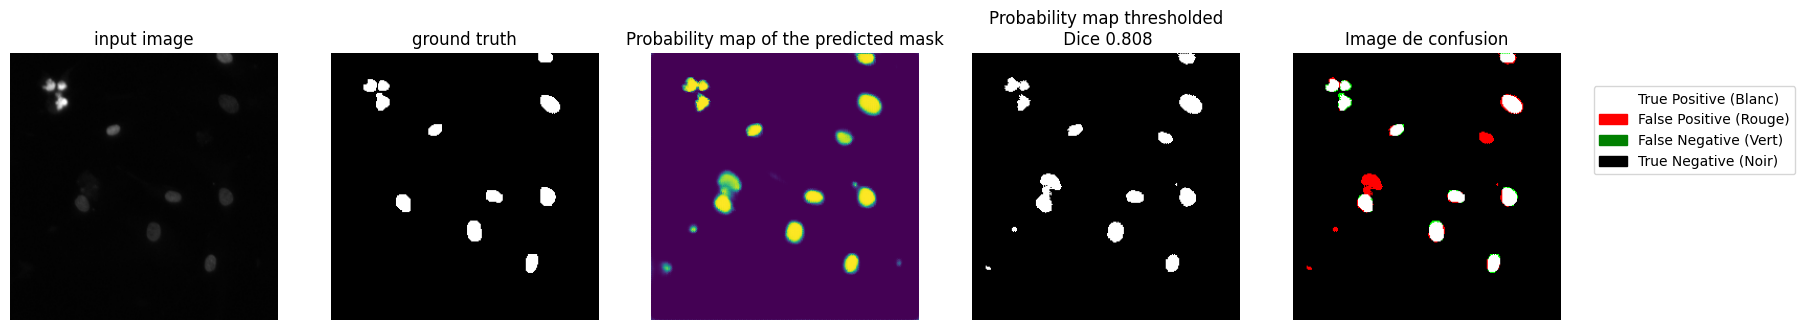

In [ ]:
pred_vis(x_val,y_val,preds_val,preds_val_t)

Application du seuillage sur les images test

In [ ]:
preds_test = model_best.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.6).astype(np.uint8)

5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step


In [ ]:
dice = K.get_value(dice_coefficient(Y_test, preds_test_t))
print("Dice coefficient:", np.around(dice,3))

Dice coefficient: 0.952


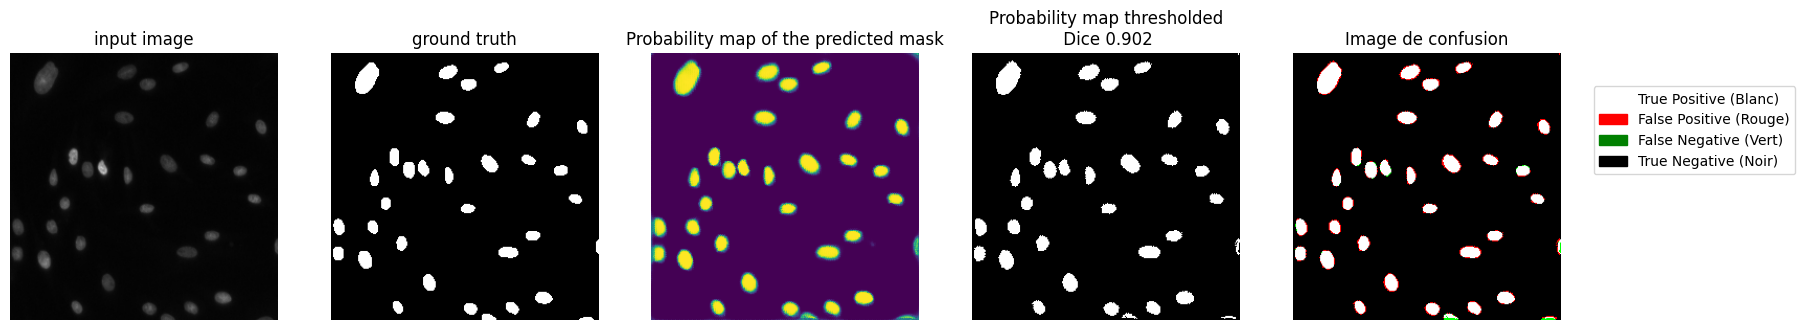

In [ ]:
pred_vis(X_test,Y_test,preds_test,preds_test_t)

## Comment déterminer le meilleur seuillage entre 0.1 jusquà 0.9 ?

Pour chaque seuillage, on applique un seuil sur les images de validation puis on mesure sa performance avec f1 score car on veut une précision élevé et un bon rappel

100%|██████████| 9/9 [00:27<00:00,  3.06s/it]


Optimizing threshold for predicted probability maps


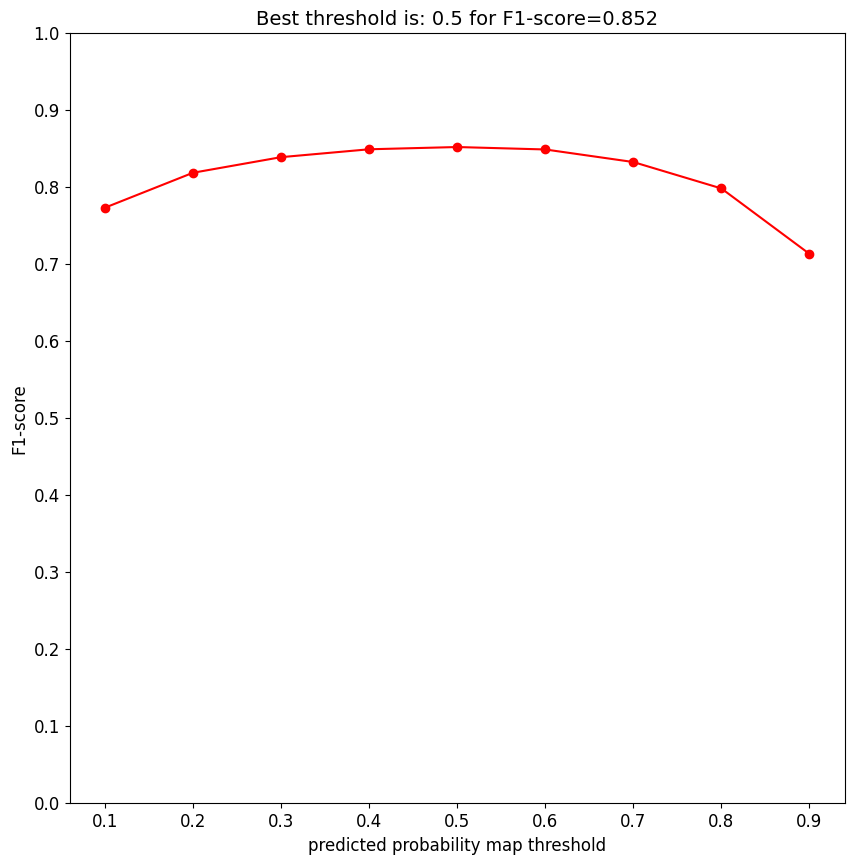

In [ ]:
thr_optimize(preds_val)

5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step
Dice coefficient: 0.959


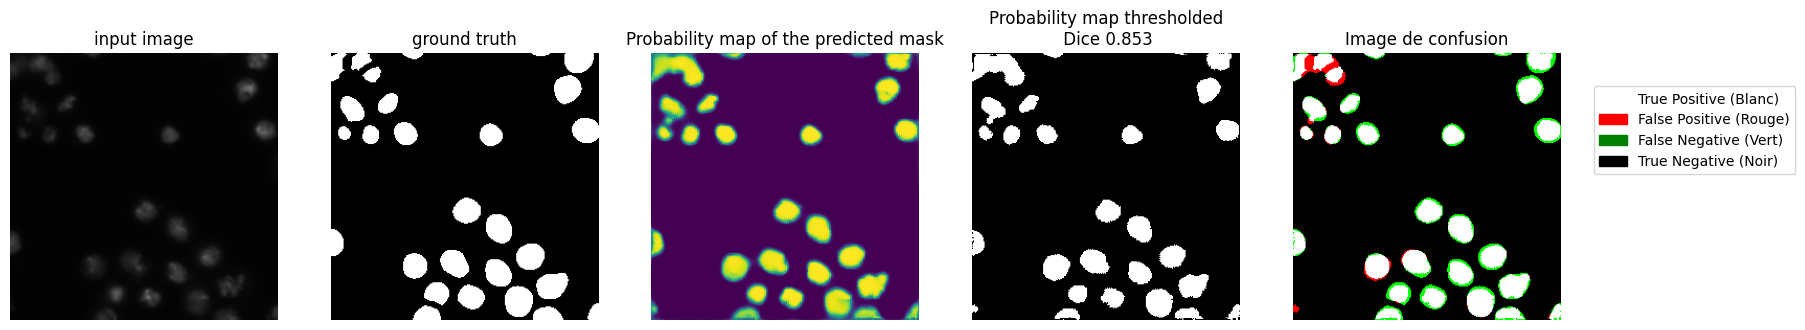

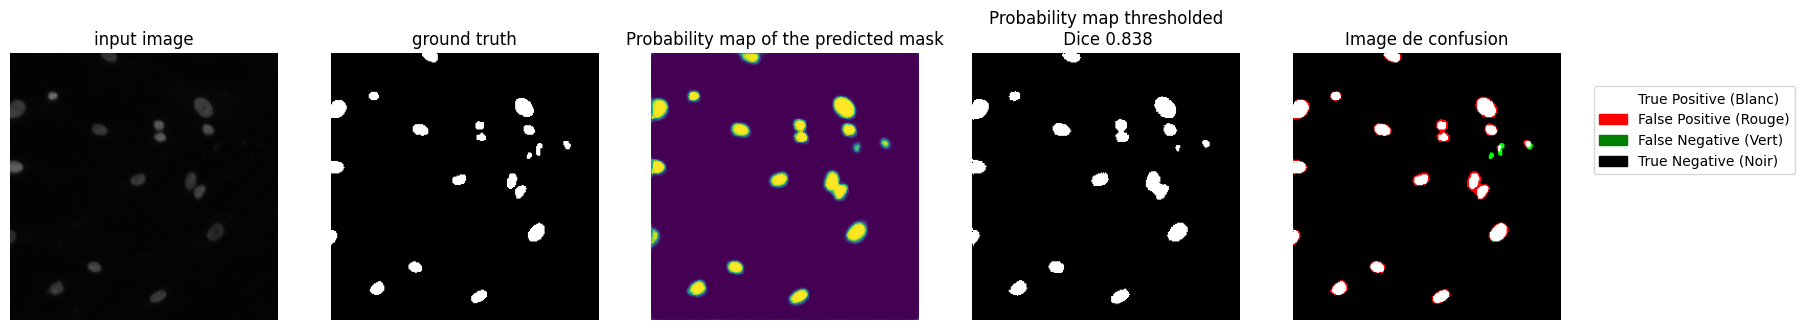

In [ ]:
preds_test = model_best.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

dice = K.get_value(dice_coefficient(preds_test, preds_test_t))
print("Dice coefficient:", np.around(dice,3))

pred_vis(X_test,Y_test,preds_test,preds_test_t)
pred_vis(X_test,Y_test,preds_test,preds_test_t)